### Transfer Learning

Based on our past experience, we humans can learn a new skill easily. We are more efficient in learning, particularly if the task in hand similar to what we have done have done in similar, for example learning a new programming language for a computer professional or driving a new type of vehicle for a seasoned driver is relatively easy based on our past experience. 
Transfer learning is an area in machine learning that aims to utilize the knowledge gained while solving one problem to solve a different but related problem. 

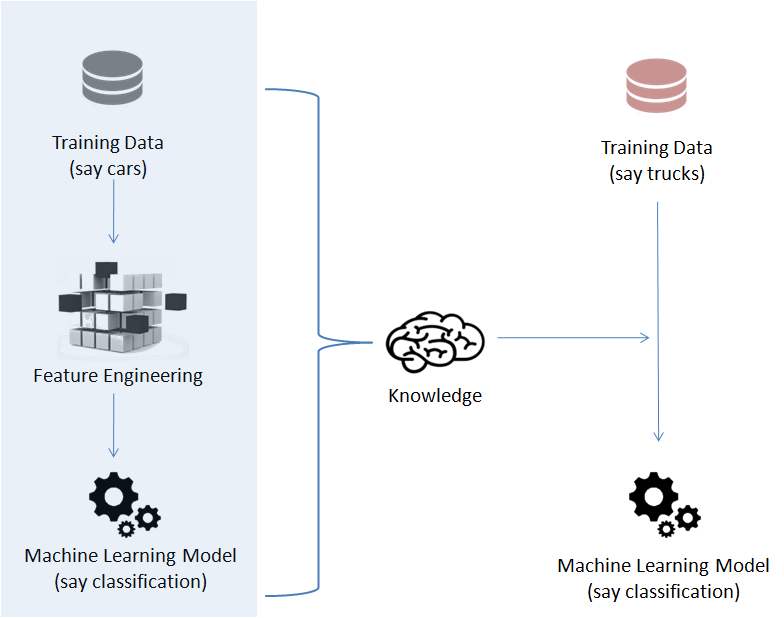

In [1]:
from IPython.display import Image
Image(filename='../Chapter 6 Figures/Transfer_Learning.png', width=600)

Nothing better than understanding through example, so let's train a simple CNN model of two level layers i.e., a feature layer and a classification layer on the first 5 digits (0 to 4) of MNIST dataset, then apply transfer learning to freeze features layer and fine-tune dense layers for the classification of digits 5 to 9. 

In [2]:
import numpy as np
np.random.seed(2017)  # for reproducibility

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

Using TensorFlow backend.


### Load data

In [3]:
batch_size = 128
nb_classes = 5
nb_epoch = 5

# input image dimensions
img_rows, img_cols = 28, 28

# number of convolutional filters to use
nb_filters = 32

# size of pooling area for max pooling
pool_size = 2

# convolution kernel size
kernel_size = 3

input_shape = (img_rows, img_cols, 1)

In [4]:
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# create two datasets one with digits below 5 and one with 5 and above
X_train_lt5 = X_train[y_train < 5]
y_train_lt5 = y_train[y_train < 5]
X_test_lt5 = X_test[y_test < 5]
y_test_lt5 = y_test[y_test < 5]

X_train_gte5 = X_train[y_train >= 5]
y_train_gte5 = y_train[y_train >= 5] - 5  # make classes start at 0 for
X_test_gte5 = X_test[y_test >= 5]         # np_utils.to_categorical
y_test_gte5 = y_test[y_test >= 5] - 5

### Train model for digits 0 to 4

In [5]:
def train_model(model, train, test, nb_classes):
    X_train = train[0].reshape((train[0].shape[0],) + input_shape)
    X_test = test[0].reshape((test[0].shape[0],) + input_shape)
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255
    X_test /= 255
    print('X_train shape:', X_train.shape)
    print(X_train.shape[0], 'train samples')
    print(X_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    Y_train = np_utils.to_categorical(train[1], nb_classes)
    Y_test = np_utils.to_categorical(test[1], nb_classes)

    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])

    model.fit(X_train, Y_train,
              batch_size=batch_size, nb_epoch=nb_epoch,
              verbose=1,
              validation_data=(X_test, Y_test))
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])

In [6]:
# define two groups of layers: feature (convolutions) and classification (dense)
feature_layers = [
    Convolution2D(nb_filters, kernel_size, kernel_size,
                  border_mode='valid',
                  input_shape=input_shape),
    Activation('relu'),
    Convolution2D(nb_filters, kernel_size, kernel_size),
    Activation('relu'),
    MaxPooling2D(pool_size=(pool_size, pool_size)),
    Dropout(0.25),
    Flatten(),
]
classification_layers = [
    Dense(128),
    Activation('relu'),
    Dropout(0.5),
    Dense(nb_classes),
    Activation('softmax')
]

# create complete model
model = Sequential(feature_layers + classification_layers)

# train model for 5-digit classification [0..4]
train_model(model, (X_train_lt5, y_train_lt5), (X_test_lt5, y_test_lt5), nb_classes)

('X_train shape:', (30596, 28, 28, 1))
(30596, 'train samples')
(5139, 'test samples')
Train on 30596 samples, validate on 5139 samples
Epoch 1/5
30596/30596 [==============================] - 55s - loss: 0.2221 - acc: 0.9310 - val_loss: 0.0644 - val_acc: 0.9800
Epoch 2/5
30596/30596 [==============================] - 59s - loss: 0.0834 - acc: 0.9747 - val_loss: 0.0384 - val_acc: 0.9883
Epoch 3/5
30596/30596 [==============================] - 57s - loss: 0.0573 - acc: 0.9833 - val_loss: 0.0223 - val_acc: 0.9928
Epoch 4/5
30596/30596 [==============================] - 57s - loss: 0.0432 - acc: 0.9869 - val_loss: 0.0170 - val_acc: 0.9942
Epoch 5/5
30596/30596 [==============================] - 57s - loss: 0.0376 - acc: 0.9890 - val_loss: 0.0154 - val_acc: 0.9947
('Test score:', 0.015360686778057639)
('Test accuracy:', 0.99474605954465845)


### Transfer existing trained model on 0 to 4 to build model for digits 5 to 9

In [7]:
# freeze feature layers and rebuild model
for layer in feature_layers:
    layer.trainable = False

# transfer: train dense layers for new classification task [5..9]
train_model(model, (X_train_gte5, y_train_gte5), (X_test_gte5, y_test_gte5), nb_classes)

('X_train shape:', (29404, 28, 28, 1))
(29404, 'train samples')
(4861, 'test samples')
Train on 29404 samples, validate on 4861 samples
Epoch 1/5
29404/29404 [==============================] - 26s - loss: 0.3964 - acc: 0.8806 - val_loss: 0.1056 - val_acc: 0.9642
Epoch 2/5
29404/29404 [==============================] - 26s - loss: 0.1386 - acc: 0.9575 - val_loss: 0.0633 - val_acc: 0.9792
Epoch 3/5
29404/29404 [==============================] - 27s - loss: 0.1043 - acc: 0.9690 - val_loss: 0.0528 - val_acc: 0.9833
Epoch 4/5
29404/29404 [==============================] - 27s - loss: 0.0877 - acc: 0.9743 - val_loss: 0.0436 - val_acc: 0.9854
Epoch 5/5
29404/29404 [==============================] - 27s - loss: 0.0769 - acc: 0.9765 - val_loss: 0.0407 - val_acc: 0.9866
('Test score:', 0.040725230788622363)
('Test accuracy:', 0.98662826567857609)


Notice that we got 99.8% test accuracy after 5 epochs for the first five digits classifier and 99.2% for the last five digits after transfer and fine-tuning.